In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [6]:

# CNN Model
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 128)
        self.fc2 = nn.Linear(128, 64)     
        self.fc3 = nn.Linear(64, 10)
        self.dropout=nn.Dropout(0.1)
    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(F.relu(self.bn1(out)))
        out = self.conv2(out)
        out = self.pool(F.relu(self.bn2(out)))
        out = torch.flatten(out,1)
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.fc3(out)
        return out



In [8]:
#Load Dataset(CIFAR10)

BatchSize=64
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train = torchvision.datasets.CIFAR10(root='./', train=True, download=False, transform=transform) 
test = torchvision.datasets.CIFAR10(root='./', train=False, download=False, transform=transform)

split=0.8
train_size=int(len(train)*split)
traindata, valdata = data.random_split(train, [train_size, len(train)-train_size])
#traindata, valdata = train_test_split(train, test_size = 0.2, random_state = 111)

trainLoader = data.DataLoader(traindata, batch_size=BatchSize, shuffle=True, num_workers=2)
validLoader = data.DataLoader(valdata, batch_size=BatchSize, shuffle=True,num_workers=2)
testLoader = data.DataLoader(test, batch_size=BatchSize, shuffle=False, num_workers=2)



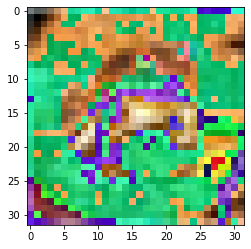

torch.Size([3, 32, 32])


In [9]:
#visualize img
img = train[0][0]
plt.imshow(transforms.ToPILImage()(img))
plt.show()
print(img.size())


In [23]:
# Parameters

device ='cuda:0' if torch.cuda.is_available() else 'cpu' #check cuda
print(device,'is available!\n')
model = net().to(device)
print(model)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), lr=0.0001)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)
criterion= nn.CrossEntropyLoss(label_smoothing=0.1)#train loss
criterion1 = nn.CrossEntropyLoss()#valid loss



cuda:0 is available!

net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Early stopping!
Finished Training


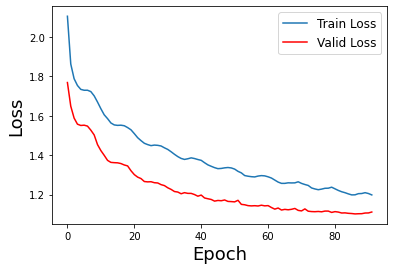

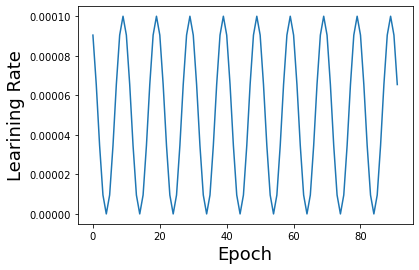

In [25]:
# Training
#store loss inf
loss={'train_loss':[],'valid_loss':[],'lr':[]}        

#early_stopping
patience=5
earlystop=0
best_loss=float('inf')

epochs = 100

for epoch in range(epochs):
    #model train
    model.train()
    tmp=[]
    with tqdm(trainLoader,leave=False) as tepoch:
        for inputs, target in tepoch:
            #set tqdm description
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            inputs, target=inputs.to(device), target.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            output = model(inputs)
            crit = criterion(output, target)

            tmp.append(crit.cpu().item())

            crit.backward()
            optimizer.step()
            tepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})

    scheduler.step()
    loss['train_loss'].append(np.average(tmp))
    
    #model valid
    model.eval()
    tmp=[]
    with tqdm(validLoader,leave=False) as vepoch:
        for inputs, target in vepoch:
            vepoch.set_description(f'ValidEpoch{epoch+1:3d}')
            inputs,target=inputs.to(device), target.to(device)

            output=model(inputs)
            crit=criterion1(output,target)

            tmp.append(crit.cpu().item())
            vepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})

    loss['valid_loss'].append(np.average(tmp))
    loss['lr'].append(scheduler.get_last_lr())
    
    # earlystopping
    cur_loss=np.average(tmp)
    if cur_loss>best_loss:
        earlystop+=1
        if earlystop>= patience:
            print('Early stopping!')
            break
    else:
        earlystop=0
        best_loss=cur_loss

print('Finished Training')

#plot training loss and valid loss

plt.plot(loss['train_loss'])
plt.plot(loss['valid_loss'],color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
plt.show()

#plot lr

plt.plot(loss['lr'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Learining Rate', fontsize=18)
plt.show()

In [26]:
#https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10 Class {airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck}
# Testing

test_acc={}
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# Test
correct = 0
total = 0

model.eval()
with tqdm(testLoader,leave=True) as tepoch:
    for inputs, labels in tepoch:
        inputs, labels= inputs.to(device), labels.to(device)
        output=model(inputs)
        _, predicted = torch.max(output,1)
        total+=labels.size(0)
        correct += (predicted == labels).sum().item()
        c=(predicted==labels).squeeze()

        for i in range(labels.size(0)):
            label=labels[i].item()
            if label not in test_acc:
                test_acc[label]=[0,0]
            else:
                test_acc[label][0]+=c[i].item()
                test_acc[label][1]+=1




for i in range(len(classes)):
    print('Accuracy of %10s : %2d %%' % (classes[i], 100 * test_acc[i][0] / test_acc[i][1]))
print()
print('Test Dataset : %d %%' % (100 * correct / total))

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 40.94it/s]

Accuracy of   Airplane : 64 %
Accuracy of Automobile : 76 %
Accuracy of       Bird : 42 %
Accuracy of        Cat : 37 %
Accuracy of       Deer : 54 %
Accuracy of        Dog : 51 %
Accuracy of       Frog : 76 %
Accuracy of      Horse : 69 %
Accuracy of       Ship : 75 %
Accuracy of      Truck : 73 %

Test Dataset : 62 %
